In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam

## Data Loading

Config initialisation

In [2]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [3]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,…,feature_49,feature_51,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,34,1,3.889038,1.509601,0.885045,2.831856,-1.201967,11,7,76,-0.271028,0.695742,0.794157,-0.038239,0.045858,0.030772,-0.900359,-0.382682,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.586801,0.250828,0.294883,0.521403,-0.682683,-0.239552,-0.460341,1.955693,1.485422,-0.253407,…,1.380354,1.116463,1.92235,0.375684,-1.258121,-0.705236,0.748627,0.643394,0.627821,1.411739,-1.36224,0.414762,0.683652,0.896076,-1.06081,-0.636584,-0.423285,0.055839,0.424335,-0.108809,1.035421,1.629745,-0.407497,-0.345388,-0.342097,-0.281208,-0.406524,-0.258637,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941
0,35,1,3.889038,1.636899,1.224167,2.786362,-1.050494,11,7,76,-0.310024,0.05155,0.600186,-0.054901,-0.167249,-0.014244,-0.885459,-0.254649,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.189785,0.945696,1.106982,0.392782,-0.657124,-0.220858,-0.466647,0.24926,0.994481,0.17161,…,1.066112,-1.037891,1.715097,0.067716,-0.876391,0.051228,0.806862,0.703435,0.148378,1.411131,-1.36224,0.41464,0.768911,0.571721,-1.158224,-0.932629,-0.209845,-0.144411,0.304465,-0.11591,0.342235,1.448319,-0.333611,-0.407654,-0.205946,-0.170852,-0.350776,-0.286903,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239
0,36,1,3.889038,1.751107,-0.195755,2.280836,-1.308689,11,7,76,-0.292135,-0.202836,0.615877,-0.075484,-0.318359,-0.049205,-0.930674,-0.666436,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.15204,0.121289,0.794614,0.664937,-0.615451,-0.169856,-0.365646,0.076389,1.351177,0.60942,…,1.095427,-1.714377,1.889433,-0.257992,-1.178176,-0.281169,1.45806,0.599523,-0.062305,1.499916,-1.36224,0.401396,0.701324,0.793441,-0.810332,-0.421096,-0.424012,-0.189834,0.255931,-0.067103,-0.06556,1.456399,-0.405195,-0.351057,-0.189416,-0.220496,-0.373879,-0.340003,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819
0,37,1,3.889038,1.869932,-1.48951,1.470981,-1.040105,11,7,76,-0.34881,-0.476177,0.599473,-0.064814,-0.145902,-0.037824,-0.917428,-0.682684,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.723722,0.289863,0.752283,0.108357,-0.439932,-0.221922,-0.311707,0.186232,1.29547,0.394812,…,0.979125,1.078464,0.791492,-0.55243,-1.282962,0.223554,1.172299,0.73975,-0.584127,1.038086,-1.36224,0.627579,0.601162,0.763969,-0.77326,-0.32353,-0.36246,-0.326542,0.226188,-0.114877,-0.216078,1.169394,-0.405249,-0.399258,-0.282878,-0.236362,-0.322532,-0.284416,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722
0,38,1,3.889038,1.653586,-1.510579,1.045217,-1.045805,11,7,76,-0.359463,-0.173339,0.599964,-0.082462,-0.182317,-0.046782,-0.532617,-0.188155,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.52142,0.685667,0.240129,0.750362,-0.025711,-0.1079

Ensure sorted by time_id to create batches not leaked

In [4]:
data = data.sort(by="time_id")

Define features and target

In [5]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

Split data

In [6]:
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

Data Wraper

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [9]:
train_data_loader = DataLoader(
    train_dataset, batch_size=2048, shuffle=False, num_workers=8
)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

## Model Evaluation

Model hyperameters

In [10]:
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

In [11]:
model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
)

Training hyperparameters

In [12]:
lr = 1e-2
device = torch.device("cuda")
alpha = 1.0
beta = 0

In [13]:
optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 20

  5%|▌         | 1/20 [00:07<02:26,  7.72s/it]

Epoch 01 | loss=923.359 | R2_rec_train=-1.3537 | R2_rec_val=0.0468 | R2_sup_train=-2.0388 | R2_sup_val=-1.3527


 10%|█         | 2/20 [00:16<02:30,  8.35s/it]

Epoch 02 | loss=268.894 | R2_rec_train=0.1561 | R2_rec_val=0.1178 | R2_sup_train=-1.5592 | R2_sup_val=-1.2190


 15%|█▌        | 3/20 [00:23<02:14,  7.89s/it]

Epoch 03 | loss=214.163 | R2_rec_train=0.2916 | R2_rec_val=0.2165 | R2_sup_train=-1.4032 | R2_sup_val=-1.2298


 20%|██        | 4/20 [00:30<01:58,  7.41s/it]

Epoch 04 | loss=184.370 | R2_rec_train=0.3764 | R2_rec_val=0.3293 | R2_sup_train=-1.1730 | R2_sup_val=-0.9448


 25%|██▌       | 5/20 [00:37<01:47,  7.16s/it]

Epoch 05 | loss=166.139 | R2_rec_train=0.4405 | R2_rec_val=0.4088 | R2_sup_train=-0.9532 | R2_sup_val=-0.7918


 30%|███       | 6/20 [00:43<01:37,  6.93s/it]

Epoch 06 | loss=208.822 | R2_rec_train=0.3666 | R2_rec_val=0.4466 | R2_sup_train=-0.7898 | R2_sup_val=-0.5480


 35%|███▌      | 7/20 [00:50<01:30,  6.95s/it]

Epoch 07 | loss=136.475 | R2_rec_train=0.5277 | R2_rec_val=0.4855 | R2_sup_train=-0.5767 | R2_sup_val=-0.5297


 40%|████      | 8/20 [00:57<01:23,  6.94s/it]

Epoch 08 | loss=135.078 | R2_rec_train=0.5316 | R2_rec_val=0.4771 | R2_sup_train=-0.5658 | R2_sup_val=-0.5361


 45%|████▌     | 9/20 [01:04<01:15,  6.82s/it]

Epoch 09 | loss=132.580 | R2_rec_train=0.5401 | R2_rec_val=0.4728 | R2_sup_train=-0.5749 | R2_sup_val=-0.5232


 50%|█████     | 10/20 [01:11<01:10,  7.03s/it]

Epoch 10 | loss=136.698 | R2_rec_train=0.5313 | R2_rec_val=0.4812 | R2_sup_train=-0.5540 | R2_sup_val=-0.5208


 55%|█████▌    | 11/20 [01:19<01:04,  7.12s/it]

Epoch 11 | loss=140.947 | R2_rec_train=0.5280 | R2_rec_val=0.5234 | R2_sup_train=-0.5301 | R2_sup_val=-0.4566


 60%|██████    | 12/20 [01:25<00:54,  6.81s/it]

Epoch 12 | loss=117.379 | R2_rec_train=0.5800 | R2_rec_val=0.5133 | R2_sup_train=-0.4955 | R2_sup_val=-0.4391


 65%|██████▌   | 13/20 [01:32<00:48,  6.90s/it]

Epoch 13 | loss=118.326 | R2_rec_train=0.5795 | R2_rec_val=0.5340 | R2_sup_train=-0.4568 | R2_sup_val=-0.4290


 70%|███████   | 14/20 [01:38<00:40,  6.67s/it]

Epoch 14 | loss=111.849 | R2_rec_train=0.5983 | R2_rec_val=0.4202 | R2_sup_train=-0.4450 | R2_sup_val=-0.4188


 75%|███████▌  | 15/20 [01:44<00:32,  6.47s/it]

Epoch 15 | loss=105.893 | R2_rec_train=0.6122 | R2_rec_val=0.5662 | R2_sup_train=-0.4173 | R2_sup_val=-0.3842


 80%|████████  | 16/20 [01:50<00:25,  6.27s/it]

Epoch 16 | loss=112.174 | R2_rec_train=0.5953 | R2_rec_val=0.5602 | R2_sup_train=-0.3678 | R2_sup_val=-0.3515


 85%|████████▌ | 17/20 [01:57<00:19,  6.45s/it]

Epoch 17 | loss=102.213 | R2_rec_train=0.6210 | R2_rec_val=0.5663 | R2_sup_train=-0.3701 | R2_sup_val=-0.3458


 90%|█████████ | 18/20 [02:02<00:12,  6.27s/it]

Epoch 18 | loss=100.757 | R2_rec_train=0.6256 | R2_rec_val=0.5715 | R2_sup_train=-0.3555 | R2_sup_val=-0.3357


 95%|█████████▌| 19/20 [02:09<00:06,  6.44s/it]

Epoch 19 | loss=99.918 | R2_rec_train=0.6284 | R2_rec_val=0.5700 | R2_sup_train=-0.3432 | R2_sup_val=-0.3188


100%|██████████| 20/20 [02:18<00:00,  6.92s/it]

Epoch 20 | loss=106.716 | R2_rec_train=0.6138 | R2_rec_val=0.5822 | R2_sup_train=-0.3208 | R2_sup_val=-0.3014


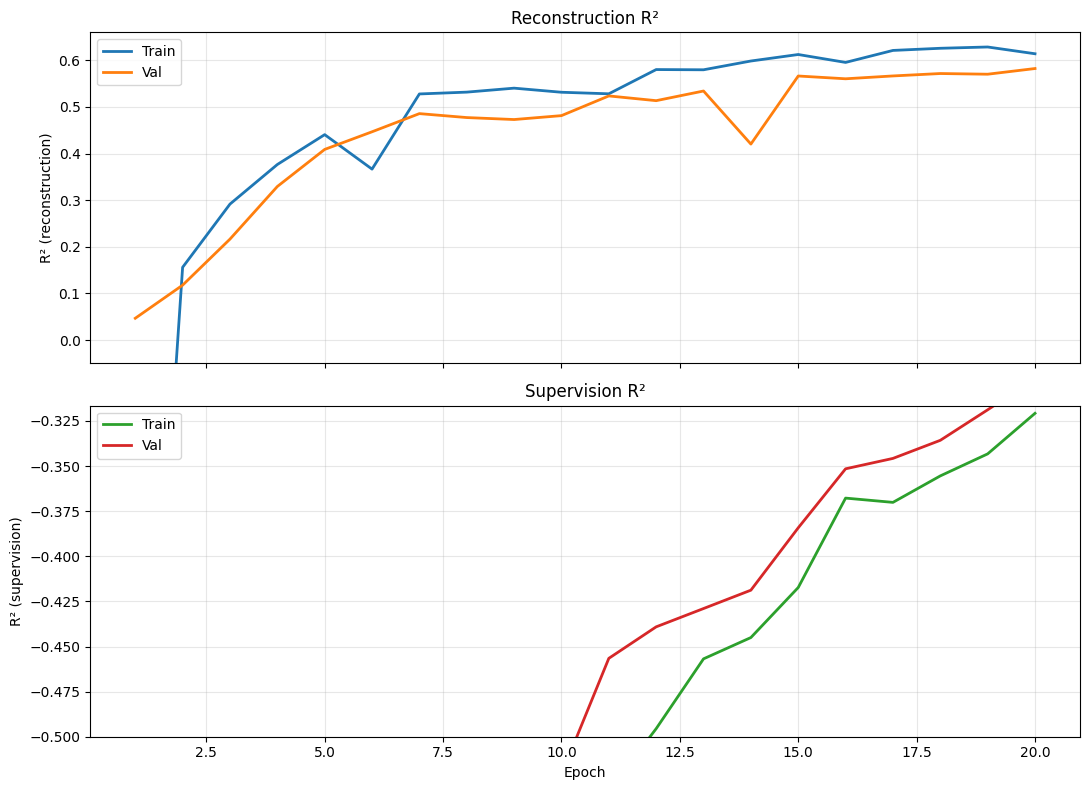

True

In [14]:
train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)